In [3]:
###Packages to manipulate data
import pandas as pd
import numpy as np

###Visualization Packages
###Install a pip package in the current Jupyter kernel
#import sys
#!{sys.executable} -m pip install missingno
import missingno
from matplotlib import pyplot as plt
import seaborn as sns


###data transformation packages
from sklearn.preprocessing import LabelEncoder

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
tabpy-server 0.2 requires futures, which is not installed.
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
###Instead of reading the files from cloud all the time, they are exported into csv files on local machine for easier access
test_data = pd.read_csv('https://storage.googleapis.com/kaggle-competitions-data/kaggle/3136/test.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1555604553&Signature=j2r03a7U%2FYQfJwehSAUH29ApFhJ%2BEsnz8xg0qnUxUo9giblXKiu3M9IHhjrTw%2BAFfCKZ2CctvbzeAaZRP%2F3tAwbCGGY6OiOa0P2x2e%2F1d05B3MIWtTg2Ps%2FtReJWKs6PGLl9XVIiAXk3eQ3qlP59dRx9XbbpU9vHlrP2XNEBuMqaTESTOmmwwHD%2FzDDPmlXc%2BzlYZjnBxp8CBErSaVmvy4CLy0jb8wObWaamw5xacPgWQbPzNUCmbHlWxSWRRgP7tUYKJoTE2LBKkhoFPRh9TAlRzOHP3H6umwpte1tVOEGFxkiButtvmYQTSmXtc75qN9zckmG4pROqC0ocjrd56g%3D%3D')
train_data = pd.read_csv('https://storage.googleapis.com/kaggle-competitions-data/kaggle/3136/train.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1555604791&Signature=B235IUuNVb9ZlhgouRJ9XAxpmsc6Bu6baYaou0k7hLIUIZNgzmwSsT47IUx8tiry%2FJWvSHdJrTE48C4JONCPdtLnFkiQ%2Fiu%2FOgU%2FPHyiXLWNFgi7mzJT6bmSsUnw9ePmdiqWoTKfrsMqlZDZ%2BWPw2DzYGcmd2NYbmJ0s%2FuyLX4oBO2rZ8VplYb0QfRjPBoKY3T6yBehxJhTOZlYjE5gXOaHeHEmBl4W0d6dfkBVYxKQRZKkLxN8otc%2B9P7DlFuvbmZPkJUAq9SAAClo2ubUULTzt2kwdtn8DtSH%2BLknk7EPyoglwU0xvORttNuVr0a9UfSdPRpnqEBcE7lPnDoT%2Bhg%3D%3D')
submission_sample = pd.read_csv('https://storage.googleapis.com/kaggle-competitions-data/kaggle/3136/gender_submission.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1555604850&Signature=G7X%2BBzrv735l%2Bo2RUSiKvMbuZpdROGhWKK7B6WeucNLD8d6MIhTJJwpnfebA9VRF7v9gTybwd0aJz4YG8rl4tyFr0RQndhCqPR6CP6FjCJjbpIZI7h37gYCMp%2BZWPIhLmgcL3%2BYsejok1%2B0VLCQJ1HIRCL2Y%2BesSDpnnwEu6mBAqojV%2BWwNzV24rqZvWuQnF%2B6IneeknKhUfMmwj0dt42ZYgXAHc2EL0FjPYTS8bH7M%2BBWy8W3N2GKkO29C9xTCUUQCKAlq1KcCQZd2nnHg93szMTwd5Av0ac%2BaPQiSp%2BRbzHhiCEiCwLMwZficNYtU9F9g6OBdcuPcAwWE2IlJ0wg%3D%3D')

**Exploring the data**

In [5]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
data_bins = pd.DataFrame()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


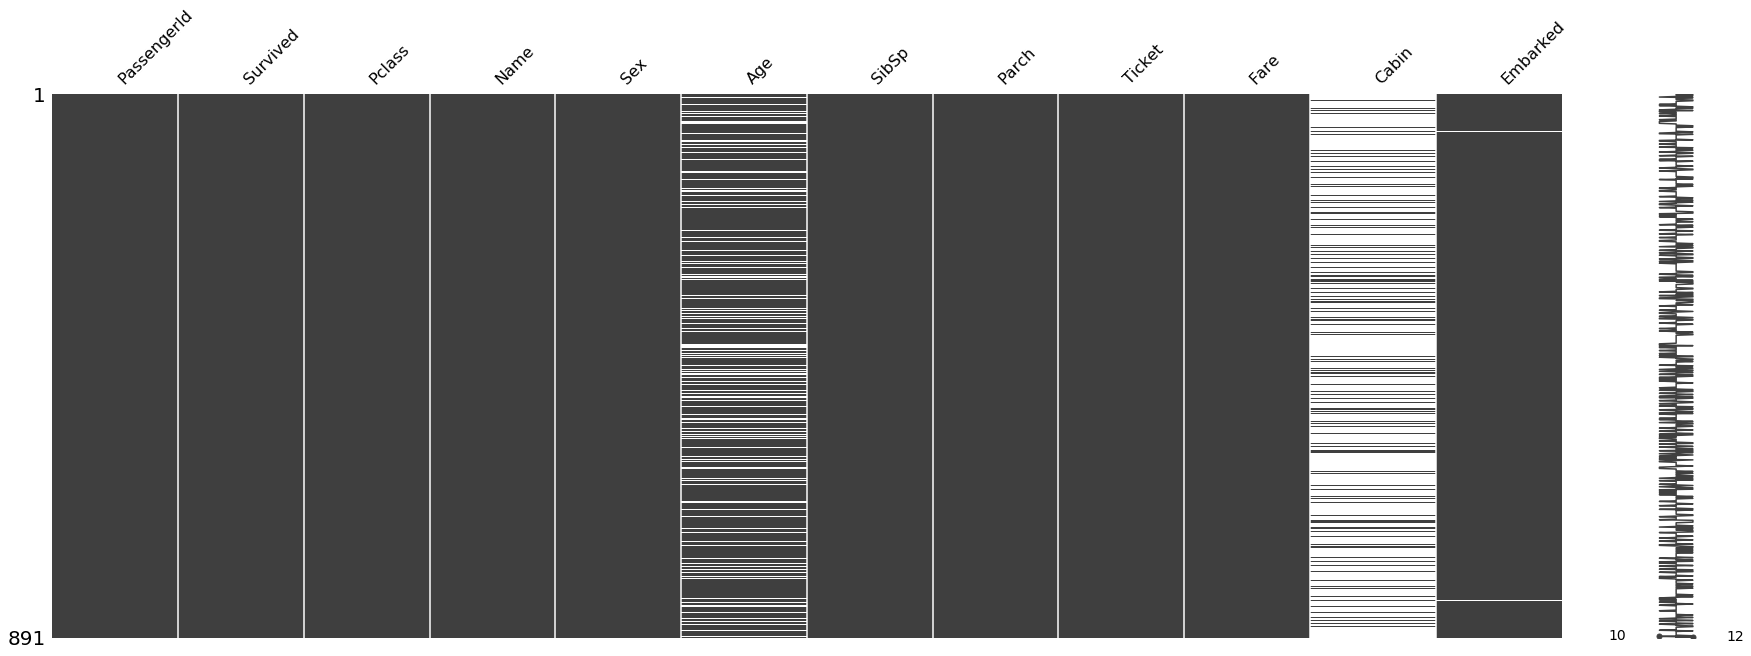

In [7]:
print(train_data.isna().sum())
missingno.matrix(train_data,figsize=(30,10))

In [8]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
##No null values in the Survived column, added to data_bins
print(train_data['Survived'].value_counts())
data_bins['Survived'] = train_data['Survived']

0    549
1    342
Name: Survived, dtype: int64


In [12]:
##No null values and clearly all passengers belonged to one of the classes - 1,2,or3. Added to data_bins
train_data['Pclass'].value_counts()
data_bins['Pclass'] = train_data['Pclass']

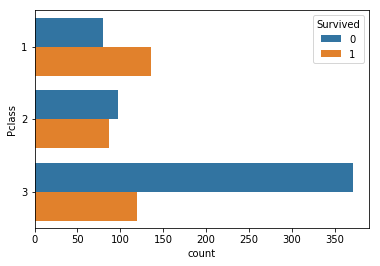

In [13]:
sns.countplot(y=train_data['Pclass'],hue=train_data['Survived'])
##1st Class has highest %survivers and in 3rd class most people perished 

In [30]:
###The name column has all unique values and will not add any value to predictive models, instead the title could be useful
train_data['title']=train_data['Name'].apply(lambda val: val.split(',')[1].split('.')[0].strip())
train_data['title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Major             2
Mlle              2
Ms                1
Don               1
the Countess      1
Lady              1
Jonkheer          1
Capt              1
Mme               1
Sir               1
Name: title, dtype: int64

In [34]:
train_data['title'].replace(['Dr','Rev','Major','Col','Mlle','Lady','Mme','Capt','Jonkheer','the Countess','Don','Sir'],'Top'
                            ,inplace=True)
train_data['title'].value_counts()
#the field has no missing values

Mr        517
Miss      183
Mrs       125
Master     40
Top        26
Name: title, dtype: int64

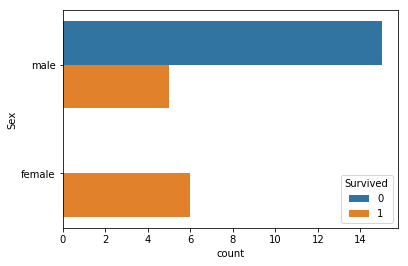

In [39]:
sns.countplot(y=train_data[train_data['title']=='Top']['Sex'],hue=train_data['Survived'])
###Women and Children have most survival rate and men have the lowest
###Top in the title means the person belongs to a very high position in the society
###In the 'Top' title, 100% women survived and very few men survived 

In [66]:
###Add 'title' field with each title representing a code(number)
data_bins['Title'] = train_data['title'].replace({'Mr':0,'Miss':1,'Mrs':2,'Master':3,'Top':4})
data_bins.iloc[2]

Survived     1.0
Pclass       3.0
Title        1.0
Sex          1.0
Age         26.0
Name: 2, dtype: float64

male      577
female    314
Name: Sex, dtype: int64


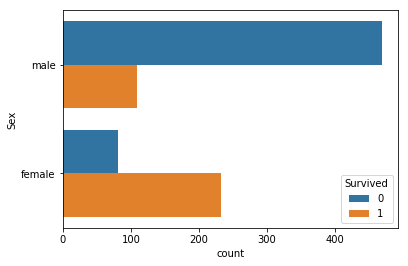

In [50]:
print(train_data['Sex'].value_counts())
sns.countplot(y=train_data['Sex'],hue=train_data['Survived'])
###No missing values in the 'Sex' column, convert the values to 0/1 and add to data_bins

In [52]:
data_bins['Sex'] = np.where(train_data['Sex']=='female',1,0)
data_bins.head()

,Survived,Pclass,Title,Sex
0,0,3,0,0
1,1,1,2,1
2,1,3,1,1
3,1,1,2,1
4,0,3,0,0


In [122]:
avg_age_title = {}
for title in pd.unique(train_data['title']):
    avg_age_title[title] = np.mean(train_data[train_data['title']==title]['Age'])

###Add age to data_bins
data_bins['Age'] = train_data['Age']

age=list()
###now fill the NAN in Age with the average of all people having the same title
for ind in list(train_data[(train_data['Age'].isna()==True)].index):
    data_bins['Age'][ind]=avg_age_title[train_data.loc[ind]['title']]


In [127]:
data_bins['Age'] = data_bins['Age'].apply(lambda val: np.ceil(val))
data_bins['Age'] = data_bins['Age'].astype(int)
data_bins.head()

,Survived,Pclass,Title,Sex,Age
0,0,3,0,0,22
1,1,1,2,1,38
2,1,3,1,1,26
3,1,1,2,1,35
4,0,3,0,0,35


(16.8, 32.6]    382
(32.6, 48.4]    325
(0.92, 16.8]    104
(48.4, 64.2]     69
(64.2, 80.0]     11
Name: Age, dtype: int64


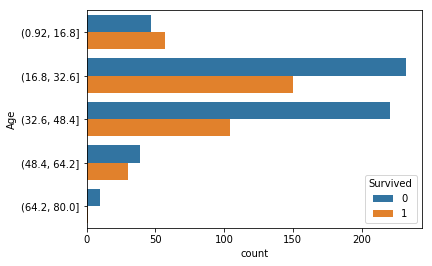

In [155]:
###create buckets of age - 0-10,11-20,...
#data_bins['Age'] = pd.cut(data_bins['Age'],5,include_lowest=True)
print(data_bins['Age'].value_counts())
sns.countplot(data=data_bins,y='Age',hue='Survived')

###we will have to convert the ranges to easily understandable values for the computer - 0,1,2,...
le = LabelEncoder()
data_bins['Age'] = le.fit_transform(data_bins['Age'])

In [148]:
###No null values in either of the fields - SibSp, Parch. Add them to the data_bins
print('SibSp null values: {0}'.format(train_data['SibSp'].isna().sum()))
print('Parch null values: ',train_data['Parch'].isna().sum())
data_bins['SibSp'] = train_data['SibSp']
data_bins['Parch'] = train_data['Parch']

SibSp null values: 0
Parch null values:  0


In [156]:
plt.subplot(1,2,1)
sns.countplot(y=data_bins['SibSp'])
plt.subplot(1,2,2)
sns.distplot(data_bins['SibSp'],)

,Survived,Pclass,Title,Sex,Age,SibSp,Parch
0,0,3,0,0,1,1,0
1,1,1,2,1,2,1,0
2,1,3,1,1,1,0,0
3,1,1,2,1,2,1,0
4,0,3,0,0,2,0,0


1    382
2    325
0    104
3     69
4     11
dtype: int64